## Quantum energy teleportation protocol to storage energy

### Import packages

In [49]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit import transpile

from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as sampler
from qiskit.visualization import plot_histogram

### Function to generate a circuit that measures the local term $Z$ or $H$

In [51]:
def qc_H(h_A,h_B,k):
    qc = QuantumCircuit(3)

    # Prepare ground state
    theta = np.arctan(np.sqrt((h_A/(2*k) + h_B/(2*k))**2+1)-(h_A/(2*k) + h_B/(2*k)))
                  
    qc.ry(-2*theta,0)
    qc.cx(0,1)
    qc.barrier()

    # Alice's projective measurement
    qc.h(0)
    qc.barrier()

    # Charlie prepare qubit C
    phi = np.arctan(np.sqrt((h_B/(2*k))**2+1)-h_B/(2*k))

    qc.cry(np.pi - 2*phi,0,2)

    qc.x(0)
    qc.cry(np.pi + 2*phi,0,2)
    qc.x(0)
    qc.barrier()

    #Bob's conditional operation
    qc.cry(2*phi,0,1)
    qc.cry(2*phi,0,2)
    
    qc.x(0)
    qc.cry(-2*phi,0,1)
    qc.cry(-2*phi,0,2)
    qc.x(0)

    # measurament of qubit B and C
    qc.measure_all()

    return qc

### Function to generate a circuit that measures the interaction term $X_0X_1$ or $V$

In [50]:
def qc_V(h_A,h_B,k):
    qc = QuantumCircuit(3)

    # Prepare ground state
    theta = np.arctan(np.sqrt((h_A/(2*k) + h_B/(2*k))**2+1)-(h_A/(2*k) + h_B/(2*k)))
                  
    qc.ry(-2*theta,0)
    qc.cx(0,1)
    qc.barrier()

    # Alice's projective measurement
    qc.h(0)
    qc.barrier()

    # Charlie prepare qubit C
    phi = np.arctan(np.sqrt((h_B/(2*k))**2+1)-h_B/(2*k))

    qc.cry(np.pi - 2*phi,0,2)

    qc.x(0)
    qc.cry(np.pi + 2*phi,0,2)
    qc.x(0)
    qc.barrier()

    #Bob's conditional operation
    qc.cry(2*phi,0,1)
    qc.cry(2*phi,0,2)
    
    qc.x(0)
    qc.cry(-2*phi,0,1)
    qc.cry(-2*phi,0,2)
    qc.x(0)

    # measurament of qubit B and C
    qc.h(1)
    qc.measure_all()

    return qc

### Show quantum circuit

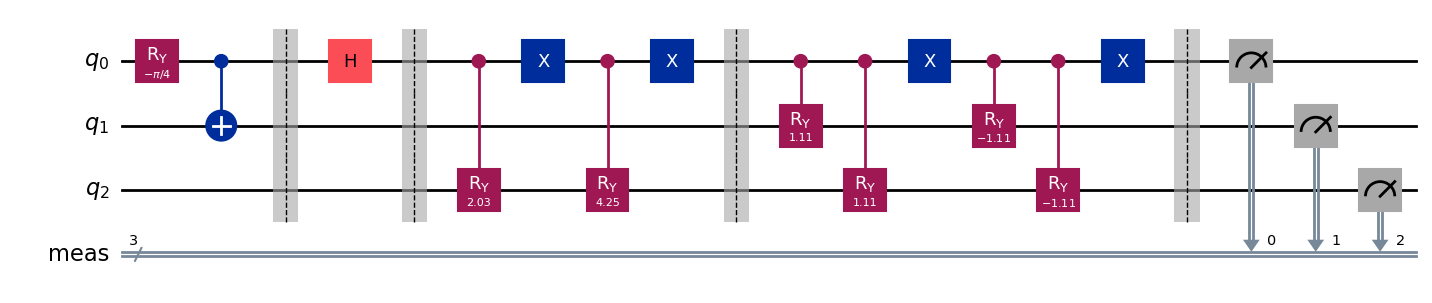

In [52]:
qc = qc_H(1,1,1)
qc.draw('mpl')

### Simulate circuit $H$ with aer simulator

In [54]:
# Initiate simulator
simulator = AerSimulator()

# Parameters
h_A = 1;h_B = 0.01; k = 0.393;
n_shots = 100000

# Generate circuit
qc = qc_H(h_A,h_B,k)
qc_B = transpile(qc, simulator, optimization_level=3)

# Run job with Sampler
jobB_sim = sampler().run([qc_B], shots=n_shots)

### Simulate circuit $V$ with aer simulator

In [53]:
# Initiate simulator
simulator = AerSimulator()

# Parameters
h_A = 1;h_B = 0.01; k = 0.393;
n_shots = 100000

# Generate circuit
qc = qc_V(h_A,h_B,k)
qc_A = transpile(qc, simulator, optimization_level=3)

# Run job with Sampler
jobA_sim = sampler().run([qc_A], shots=n_shots)

### Show Results for simulated circuit $H$

Alice's local energy =  0.7946 ± 0.0031622280752659194
H_B =  0.0140208 ± 2.5248755882221205e-05
H_C =  1.572 ± 1.0532500405730103e-18


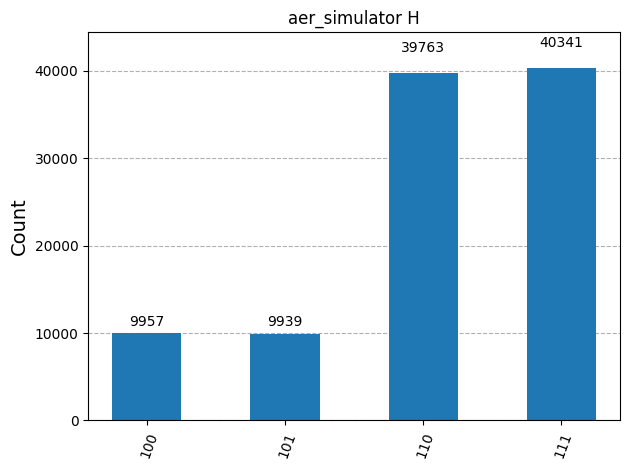

In [56]:
result = jobB_sim.result()[0]
counts = result.data.meas.get_counts()

ene_A = 0.789
ene_B = 0.008
ene_C = 0.786

error_A = []
error_B = []
error_C = []
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_A += -h_A*(-1)**int(bit_string[0])*count/n_shots
        ene_B += -h_B*(-1)**int(bit_string[1])*count/n_shots      
        ene_C += -0.786*(-1)**int(bit_string[2])*count/n_shots

        for i in range(count):
            error_A.append(-h_A*(-1)**int(bit_string[0]))
            error_B.append(-h_B*(-1)**int(bit_string[1]))
            error_C.append(-0.786*(-1)**int(bit_string[2]))

print("Alice's local energy = ",ene_A,"±",np.std(error_A)/np.sqrt(n_shots))
print("H_B = ",ene_B,"±",np.std(error_B)/np.sqrt(n_shots))
print("H_C = ",ene_C,"±",np.std(error_C)/np.sqrt(n_shots))

plot_histogram(counts, title="aer_simulator H")

### Show results for simulated circuit $V$

Interacting energy, V =  -0.14337911999999997 ± 0.002485545068954024


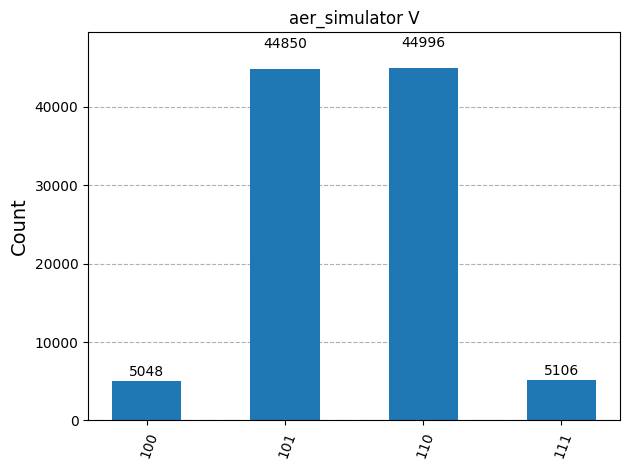

In [55]:
result = jobA_sim.result()[0]
counts = result.data.meas.get_counts()

ene_V = 0.483

error_V = []
for orig_bit_string, count in counts.items():
        bit_string = orig_bit_string[::-1]

        ene_V += 2*k*(-1)**int(bit_string[0])*(-1)**int(bit_string[1])*count/n_shots

        for i in range(count):
            error_V.append(2*k*(-1)**(int(bit_string[1])))

print("Interacting energy, V = ",ene_V,"±",np.std(error_V)/np.sqrt(n_shots))

plot_histogram(counts, title='aer_simulator V')